In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,random_split,Subset,WeightedRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from PIL import Image,ImageFile

In [21]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/isic-2019")
print(path)

/kaggle/input/isic-2019


In [24]:
training_csv=pd.read_csv(f"/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")

In [25]:
training_csv.head(10)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ISIC_0000010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
training_csv.tail(10)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
25321,ISIC_0073240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25322,ISIC_0073241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25323,ISIC_0073244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25324,ISIC_0073245,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25325,ISIC_0073246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25330,ISIC_0073254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
training_csv.shape

(25331, 10)

In [28]:
training_csv["UNK"].sum() #All the labels are known

np.float64(0.0)

In [29]:
images_dirpath="/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

In [30]:
!ls /kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input | head

ATTRIBUTION.txt
ISIC_0000000.jpg
ISIC_0000001.jpg
ISIC_0000002.jpg
ISIC_0000003.jpg
ISIC_0000004.jpg
ISIC_0000006.jpg
ISIC_0000007.jpg
ISIC_0000008.jpg
ISIC_0000009.jpg
ls: write error: Broken pipe


In [31]:
# plt.imshow(plt.imread(f'{images_dirpath}/ISIC_0000009.jpg'))
# plt.show()

In [32]:
sample_image=plt.imread(f'{images_dirpath}/ISIC_0000006.jpg')
print(sample_image.shape)

(767, 1022, 3)


In [33]:
# Organizing the Data
!path="/kaggle/input/isic-2019"
!ls $path

ISIC_2019_Training_GroundTruth.csv  ISIC_2019_Training_Metadata.csv
ISIC_2019_Training_Input


In [34]:
if not os.path.isdir("Image_Classifiers"):
  os.mkdir("Image_Classifiers")

In [35]:
idx=0
for image_name in training_csv["image"]:
  class_dir_path="Image_Classifiers"
  for cancer_type in range(1,9):
    if training_csv.iloc[idx,cancer_type].astype('int') == 1:
      class_dir_path=os.path.join(class_dir_path,f"class_label_{cancer_type}")
  if not os.path.isdir(class_dir_path):
    os.mkdir(class_dir_path)
  image_path=os.path.join(class_dir_path,f"{image_name}.jpg")
  orig_image_path=f"{images_dirpath}/{image_name}.jpg"
  if not os.path.isfile(image_path):
    shutil.copy(orig_image_path,image_path)
  idx+=1

In [36]:
corrupted_files=[]
fraction_classes=np.zeros(8)
i=0
for sub_folder in os.listdir("Image_Classifiers"):
  for img in os.listdir(os.path.join("Image_Classifiers",sub_folder)):
    i+=1
    img_path=os.path.join("Image_Classifiers",sub_folder,img)
    try:
      with Image.open(img_path) as checking_img:
        checking_img.verify()
    except:
      corrupted_files.append(img_path)
  print(os.path.join("Image_Classifiers",sub_folder),i)
  # print(sub_folder.split('_')[2])
  fraction_classes[int(sub_folder.split('_')[2])-1]=i
  i=0
fraction_classes

Image_Classifiers/class_label_4 867
Image_Classifiers/class_label_2 12875
Image_Classifiers/class_label_8 628
Image_Classifiers/class_label_1 4522
Image_Classifiers/class_label_6 239
Image_Classifiers/class_label_5 2624
Image_Classifiers/class_label_7 253
Image_Classifiers/class_label_3 3323


array([ 4522., 12875.,  3323.,   867.,  2624.,   239.,   253.,   628.])

In [37]:
fraction_classes/=np.sum(fraction_classes)

In [38]:
print(corrupted_files)
for file in corrupted_files:
  os.remove(file)

[]


In [39]:
dataset = datasets.ImageFolder("Image_Classifiers")
total_size=len(dataset)
train_batch_size=int(0.8*total_size)
test_batch_size=int(0.05*total_size)

train_idx, test_idx,_ = random_split(
    range(total_size),
    [train_batch_size, test_batch_size, total_size-train_batch_size-test_batch_size]
    )

input_img_size=96

train_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

visual_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor()
])

train_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=train_transform),
    train_idx
)

test_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=test_transform),
    test_idx
)

visual_test_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=visual_transform),
    test_idx
)

targets = np.array(train_dataset.dataset.targets)[train_dataset.indices]
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts

sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
# sampler=WeightesRandomSampler(weights=)
train_loader=DataLoader(train_dataset,batch_size=64,sampler=sampler)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=True)
visual_test_loader=DataLoader(visual_test_dataset,batch_size=24,shuffle=True)


In [40]:
total_size

25331

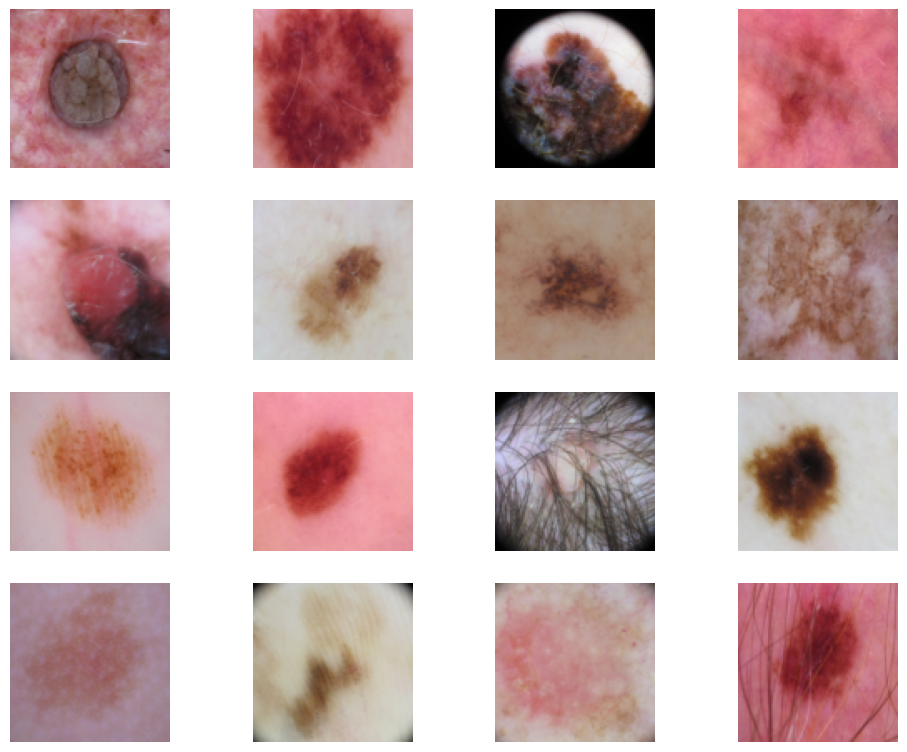

In [41]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
def visualize(visualizer_loader,n=5):
    x, y = next(iter(visualizer_loader))
    x, y = x.to(device), y.to(device)
    plt.figure(figsize=(12,12))
    for i in range(n):
        plt.subplot(n//4+1, 4, i+1)
        plt.imshow(x[i].cpu().squeeze().permute(1,2,0))
        plt.axis('off')
    plt.show()
visualize(visual_test_loader,16)

In [42]:
def train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,epochs=5):
  for epoch in range(epochs):
    model.train()
    total_loss=0
    total=0
    correct=0
    step=0
    for x,y in train_loader:
      step+=1
      x,y=x.to(device),y.to(device)
      optimizer.zero_grad()
      logits=model(x)
      loss=loss_fn(logits,y)
      loss.backward()
      optimizer.step()
      total_loss+=loss.item()
      pred=logits.argmax(dim=1)
      correct+=(pred==y).sum().item()
      total+=y.size(0)
      if step%20==0:
          print(f"Step {step} : Intermediate Accuracy = {100*correct/total :.2f}")
    print(f"Epoch {epoch+1}")
    print(f"Loss : {total_loss:.4f}")
    print("Training Accuracy")
    train_accuracy.append(100*correct/total)
    print(f"Accuracy: {100*correct/total :.2f}")
    print("Testing Accuracy")
    test_accuracy.append(test_model(model,test_loader))
    # train_accuracy.append(test_model(model,train_loader))

def test_model(model,test_loader):
  model.eval()
  correct=0
  total=0
  with torch.no_grad():
    for x,y in test_loader:
      x,y=x.to(device),y.to(device)
      logits=model(x)
      pred=logits.argmax(dim=1)
      correct+=(pred==y).sum().item()
      total+=y.size(0)
  print(f"Accuracy: {100*correct/total :.2f}")
  return 100*correct/total

In [43]:
class CNN_Model(nn.Module):
  def __init__(self):
    super(CNN_Model,self).__init__()

  def forward(self):
    pass

In [44]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return nn.functional.relu(self.fn(x) + x)
def conv_block(input_channel,output_channel):
    return nn.Sequential(
        nn.Conv2d(input_channel, output_channel, 3, padding=1),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(),
        nn.Conv2d(output_channel, output_channel, 3, padding=1),
        nn.BatchNorm2d(output_channel)
    )

In [303]:
from collections import Counter

def class_distribution(loader):
    counter = Counter()
    for _, labels in loader:
        counter.update(labels.cpu().numpy())
    return counter

print(class_distribution(train_loader))
print(class_distribution(test_loader))

Counter({np.int64(7): 2604, np.int64(6): 2578, np.int64(4): 2572, np.int64(3): 2563, np.int64(2): 2506, np.int64(1): 2496, np.int64(5): 2486, np.int64(0): 2459})
Counter({np.int64(1): 646, np.int64(0): 240, np.int64(2): 152, np.int64(4): 132, np.int64(3): 43, np.int64(7): 32, np.int64(6): 13, np.int64(5): 8})


In [45]:
"""
Resnet 18 / Resnet 50
Transfer Learning--Fine Tuning/Feature Extraction
"""

'\nResnet 18 / Resnet 50\nTransfer Learning--Fine Tuning/Feature Extraction\n'

In [46]:
dataset = datasets.ImageFolder("Image_Classifiers")
total_size=len(dataset)
train_batch_size=int(0.8*total_size)
test_batch_size=int(0.05*total_size)

train_idx, test_idx,_ = random_split(
    range(total_size),
    [train_batch_size, test_batch_size, total_size-train_batch_size-test_batch_size]
    )

input_img_size=224

train_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

visual_transform = transforms.Compose([
    transforms.Resize((input_img_size,input_img_size)),
    transforms.ToTensor()
])

train_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=train_transform),
    train_idx
)

test_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=test_transform),
    test_idx
)

visual_test_dataset = Subset(
    datasets.ImageFolder("Image_Classifiers", transform=visual_transform),
    test_idx
)

# targets of the training subset
targets = np.array(train_dataset.dataset.targets)[train_dataset.indices]
# print(targets)
# count samples per class
class_counts = np.bincount(targets)
# print(class_counts)
# inverse frequency weights
class_weights = 1.0 / class_counts

# assign a weight to each sample
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
# sampler=WeightesRandomSampler(weights=)
train_loader=DataLoader(train_dataset,batch_size=64,sampler=sampler)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=True)
visual_test_loader=DataLoader(visual_test_dataset,batch_size=24,shuffle=True)


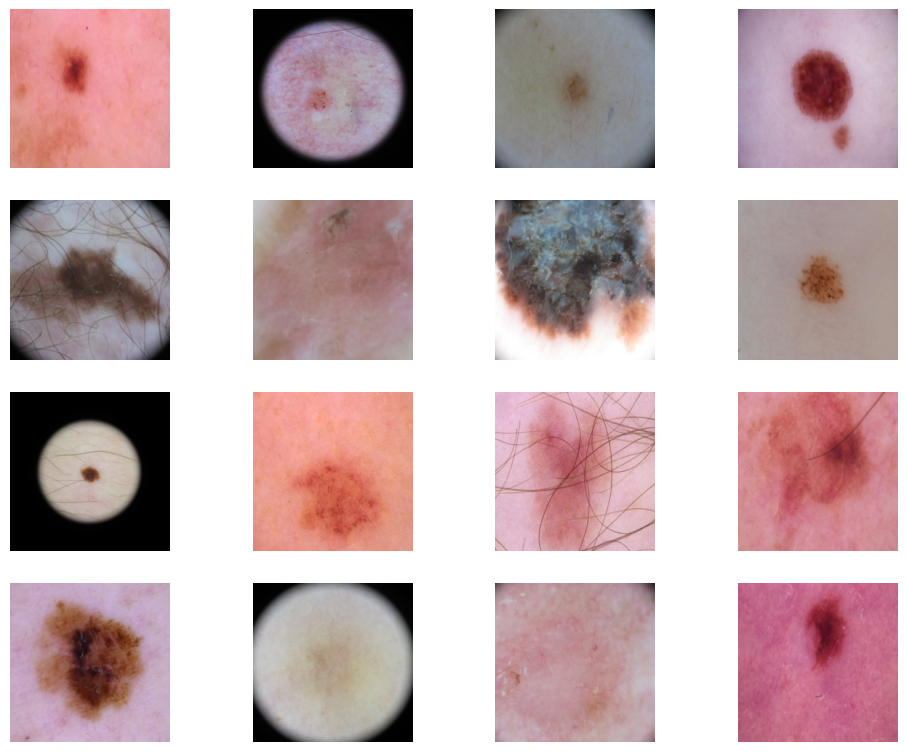

In [47]:
visualize(visual_test_loader,16)

In [48]:
Resnet18_pretrainedmodel = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [49]:
Resnet18_pretrainedmodel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
model=nn.Sequential(Resnet18_pretrainedmodel,
                    nn.Linear(1000,128),
                   nn.BatchNorm1d(128),
                   nn.ReLU(),
                   nn.Linear(128,8),
                   )
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
# test_model(model,test_loader)
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,10)
test_model(model,test_loader)

Step 20 : Intermediate Accuracy = 42.19
Step 40 : Intermediate Accuracy = 50.62
Step 60 : Intermediate Accuracy = 55.78
Step 80 : Intermediate Accuracy = 58.87
Step 100 : Intermediate Accuracy = 61.30
Step 120 : Intermediate Accuracy = 63.53
Step 140 : Intermediate Accuracy = 65.33
Step 160 : Intermediate Accuracy = 66.81
Step 180 : Intermediate Accuracy = 68.09
Step 200 : Intermediate Accuracy = 69.20
Step 220 : Intermediate Accuracy = 70.10
Step 240 : Intermediate Accuracy = 71.11
Step 260 : Intermediate Accuracy = 71.92
Step 280 : Intermediate Accuracy = 72.70
Step 300 : Intermediate Accuracy = 73.48
Epoch 1
Loss : 244.1137
Training Accuracy
Accuracy: 73.98
Testing Accuracy
Accuracy: 63.03
Step 20 : Intermediate Accuracy = 82.89
Step 40 : Intermediate Accuracy = 83.48
Step 60 : Intermediate Accuracy = 84.58
Step 80 : Intermediate Accuracy = 84.90
Step 100 : Intermediate Accuracy = 85.27
Step 120 : Intermediate Accuracy = 85.35
Step 140 : Intermediate Accuracy = 85.42
Step 160 : Inte

74.40758293838863

In [51]:
model5=model
train_accuracy_5=train_accuracy
test_accuracy_5=test_accuracy
test_model(model5,test_loader)

Accuracy: 74.41


74.40758293838863

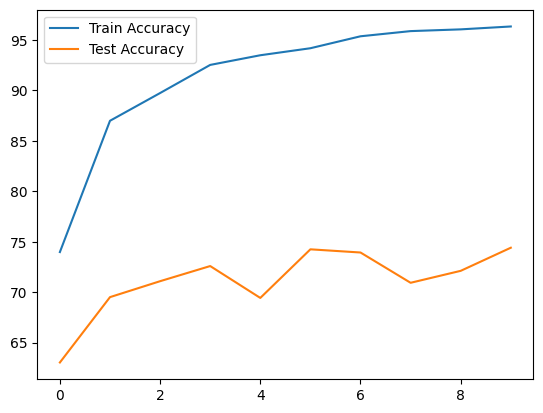

In [52]:
plt.plot(train_accuracy_5,label="Train Accuracy")
plt.plot(test_accuracy_5,label="Test Accuracy")
plt.legend()
plt.show()

In [51]:
model=nn.Sequential(Resnet18_pretrainedmodel,
                   nn.Linear(1000,128),
                   nn.BatchNorm1d(128),
                   nn.ReLU(),
                   nn.Dropout(0.3),
                   nn.Linear(128,128),
                   nn.BatchNorm1d(128),
                   nn.ReLU(),
                   nn.Dropout(0.3),
                   nn.Linear(128,8),
                   )
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,10)
test_model(model,test_loader)

Step 20 : Intermediate Accuracy = 82.42
Step 40 : Intermediate Accuracy = 89.06
Step 60 : Intermediate Accuracy = 91.82
Step 80 : Intermediate Accuracy = 93.22
Step 100 : Intermediate Accuracy = 93.75
Step 120 : Intermediate Accuracy = 94.22
Step 140 : Intermediate Accuracy = 94.50
Step 160 : Intermediate Accuracy = 94.82
Step 180 : Intermediate Accuracy = 94.87
Step 200 : Intermediate Accuracy = 94.98
Step 220 : Intermediate Accuracy = 95.03
Step 240 : Intermediate Accuracy = 95.18
Step 260 : Intermediate Accuracy = 95.23
Step 280 : Intermediate Accuracy = 95.23
Step 300 : Intermediate Accuracy = 95.24
Epoch 1
Loss : 96.5821
Training Accuracy
Accuracy: 95.26
Testing Accuracy
Accuracy: 67.14
Step 20 : Intermediate Accuracy = 95.94
Step 40 : Intermediate Accuracy = 95.78
Step 60 : Intermediate Accuracy = 95.86
Step 80 : Intermediate Accuracy = 96.21
Step 100 : Intermediate Accuracy = 96.09
Step 120 : Intermediate Accuracy = 96.15
Step 140 : Intermediate Accuracy = 96.26
Step 160 : Inter

70.7740916271722

In [52]:
model6=model
train_accuracy_6=train_accuracy
test_accuracy_6=test_accuracy
test_model(model6,test_loader)

Accuracy: 70.77


70.7740916271722

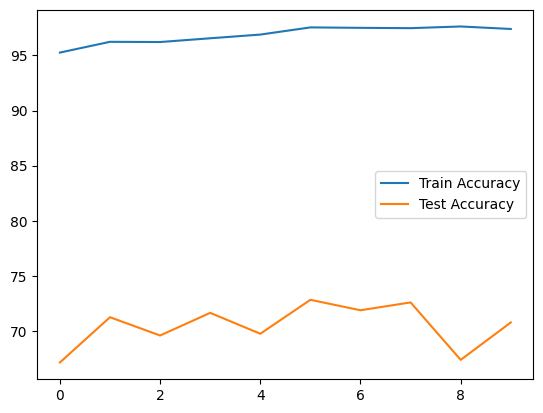

In [53]:
plt.plot(train_accuracy_6,label="Train Accuracy")
plt.plot(test_accuracy_6,label="Test Accuracy")
plt.legend()
plt.show()

In [54]:
model=nn.Sequential(Resnet18_pretrainedmodel,
                   nn.Linear(1000,128),
                   nn.BatchNorm1d(128),
                   nn.ReLU(),
                   nn.Dropout(0.5),
                   nn.Linear(128,128),
                   nn.BatchNorm1d(128),
                   nn.ReLU(),
                   nn.Dropout(0.5),
                   nn.Linear(128,8),
                   )
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,10)
test_model(model,test_loader)

Step 20 : Intermediate Accuracy = 72.34
Step 40 : Intermediate Accuracy = 83.79
Step 60 : Intermediate Accuracy = 88.02
Step 80 : Intermediate Accuracy = 90.57
Step 100 : Intermediate Accuracy = 92.03
Step 120 : Intermediate Accuracy = 93.15
Step 140 : Intermediate Accuracy = 93.87
Step 160 : Intermediate Accuracy = 94.30
Step 180 : Intermediate Accuracy = 94.57
Step 200 : Intermediate Accuracy = 94.80
Step 220 : Intermediate Accuracy = 95.04
Step 240 : Intermediate Accuracy = 95.20
Step 260 : Intermediate Accuracy = 95.28
Step 280 : Intermediate Accuracy = 95.38
Step 300 : Intermediate Accuracy = 95.50
Epoch 1
Loss : 121.4450
Training Accuracy
Accuracy: 95.55
Testing Accuracy
Accuracy: 69.67
Step 20 : Intermediate Accuracy = 97.97
Step 40 : Intermediate Accuracy = 97.54
Step 60 : Intermediate Accuracy = 97.06
Step 80 : Intermediate Accuracy = 97.01
Step 100 : Intermediate Accuracy = 96.78
Step 120 : Intermediate Accuracy = 96.69
Step 140 : Intermediate Accuracy = 96.65
Step 160 : Inte

71.32701421800948

In [55]:
model7=model
train_accuracy_7=train_accuracy
test_accuracy_7=test_accuracy
test_model(model7,test_loader)

Accuracy: 71.33


71.32701421800948

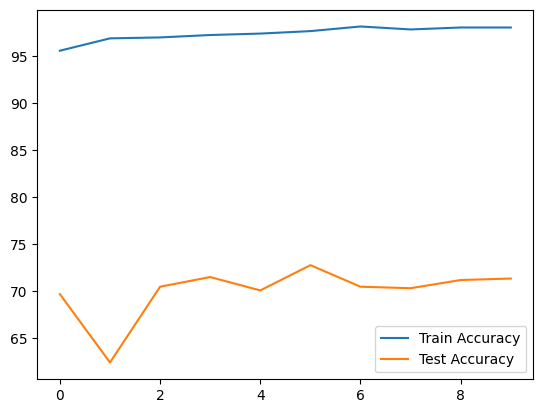

In [56]:
plt.plot(train_accuracy_7,label="Train Accuracy")
plt.plot(test_accuracy_7,label="Test Accuracy")
plt.legend()
plt.show()

In [53]:
model=nn.Sequential(Resnet18_pretrainedmodel,
                    nn.Linear(1000,64),
                   nn.BatchNorm1d(64),
                   nn.ReLU(),
                   nn.Linear(64,8),
                   )
model=model.to(device)
optimizer=optim.Adam(model.parameters(),lr=0.0003,weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
train_accuracy=[]
test_accuracy=[]
# test_model(model,test_loader)
train_model(model,train_loader,test_loader,optimizer,loss_fn,train_accuracy,test_accuracy,10)
test_model(model,test_loader)

Step 20 : Intermediate Accuracy = 90.86
Step 40 : Intermediate Accuracy = 93.71
Step 60 : Intermediate Accuracy = 94.71
Step 80 : Intermediate Accuracy = 95.16
Step 100 : Intermediate Accuracy = 95.67
Step 120 : Intermediate Accuracy = 95.91
Step 140 : Intermediate Accuracy = 96.15
Step 160 : Intermediate Accuracy = 96.42
Step 180 : Intermediate Accuracy = 96.47
Step 200 : Intermediate Accuracy = 96.45
Step 220 : Intermediate Accuracy = 96.58
Step 240 : Intermediate Accuracy = 96.70
Step 260 : Intermediate Accuracy = 96.71
Step 280 : Intermediate Accuracy = 96.75
Step 300 : Intermediate Accuracy = 96.78
Epoch 1
Loss : 99.0288
Training Accuracy
Accuracy: 96.79
Testing Accuracy
Accuracy: 74.17
Step 20 : Intermediate Accuracy = 96.88
Step 40 : Intermediate Accuracy = 96.52
Step 60 : Intermediate Accuracy = 96.25
Step 80 : Intermediate Accuracy = 96.17
Step 100 : Intermediate Accuracy = 96.14
Step 120 : Intermediate Accuracy = 96.16
Step 140 : Intermediate Accuracy = 96.26
Step 160 : Inter

75.19747235387045

In [54]:
model8=model
train_accuracy_8=train_accuracy
test_accuracy_8=test_accuracy
test_model(model8,test_loader)

Accuracy: 75.20


75.19747235387045

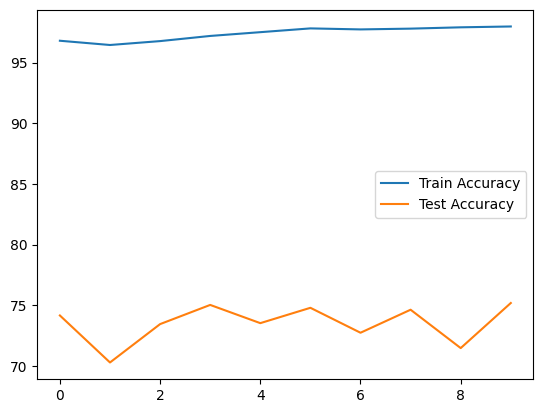

In [59]:
plt.plot(train_accuracy_8,label="Train Accuracy")
plt.plot(test_accuracy_8,label="Test Accuracy")
plt.legend()
plt.show()

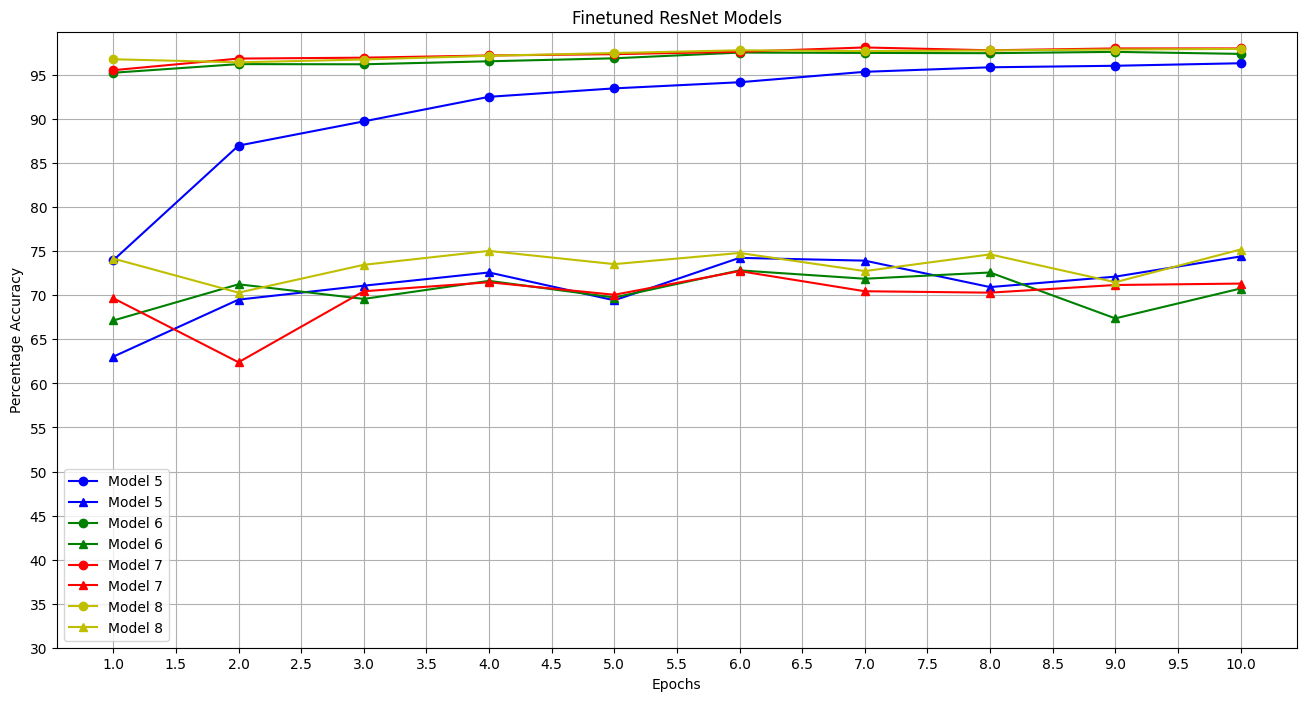

In [63]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(1,11),train_accuracy_5,marker='o',c='b',label="Model 5")
plt.plot(np.arange(1,11),test_accuracy_5,marker='^',c='b',label="Model 5")
plt.plot(np.arange(1,11),train_accuracy_6,marker='o',c='g',label="Model 6")
plt.plot(np.arange(1,11),test_accuracy_6,marker='^',c='g',label="Model 6")
plt.plot(np.arange(1,11),train_accuracy_7,marker='o',c='r',label="Model 7")
plt.plot(np.arange(1,11),test_accuracy_7,marker='^',c='r',label="Model 7")
plt.plot(np.arange(1,11),train_accuracy_8,marker='o',c='y',label="Model 8")
plt.plot(np.arange(1,11),test_accuracy_8,marker='^',c='y',label="Model 8")
plt.legend()
plt.grid()
plt.title("Finetuned ResNet Models")
plt.xlabel("Epochs")
plt.ylabel("Percentage Accuracy")
plt.xticks(np.arange(1,10.5,0.5))
plt.yticks(np.arange(30,100,5))
plt.show()

In [56]:
#Metrics
from torchmetrics.classification import (MulticlassConfusionMatrix,MulticlassAccuracy,MulticlassPrecision,MulticlassRecall,
                                        MulticlassF1Score,MulticlassAUROC,MulticlassPrecisionRecallCurve)
def model_metrics(model,test_loader,num_classes):
    model.eval()
    correct=0
    total=0
    confusion_matrix=MulticlassConfusionMatrix(num_classes=num_classes).to(device)
    accuracy=MulticlassAccuracy(num_classes=num_classes).to(device)
    precision=MulticlassPrecision(num_classes=num_classes).to(device)
    recall=MulticlassRecall(num_classes=num_classes).to(device)
    f1score=MulticlassF1Score(num_classes=num_classes).to(device)
    auc=MulticlassAUROC(num_classes=num_classes,average="macro").to(device)
    pr_curve=MulticlassPrecisionRecallCurve(num_classes=num_classes).to(device)
    metrics=[confusion_matrix,accuracy,precision,recall,f1score,auc,pr_curve]
    with torch.no_grad():
        for x,y in test_loader:
            x,y=x.to(device),y.to(device)
            logits=model(x)
            probs=torch.softmax(logits,dim=1)
            pred=logits.argmax(dim=1)
            for metric in metrics:
                metric.update(logits,y)
            correct+=(pred==y).sum().item()
            total+=y.size(0)
            
    
    print("Accuracy :", 100*accuracy.compute().item())
    print("Precision:", 100*precision.compute().item())
    print("Recall   :", 100*recall.compute().item())
    print("F1-score :", 100*f1score.compute().item())
    print("Confusion Matrix:\n", confusion_matrix.compute().detach().cpu().numpy())
    print("AOC:",auc.compute().item())
    precision,recall,thresholds=pr_curve.compute()
    for i in range(num_classes):
        plt.plot(recall[i].detach().cpu().numpy(),precision[i].detach().cpu().numpy(),label=f"Class = {i}")
    plt.title("PR Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    for metric in metrics:
                metric.reset()
    
    print(f"Raw Accuracy: {100*(correct/total) :.2f}")

Accuracy : 43.30083131790161
Precision: 84.50944423675537
Recall   : 43.30083131790161
F1-score : 49.782317876815796
Confusion Matrix:
 [[108 105   8   0   1   0   0   0]
 [ 20 614   4   0   0   0   0   0]
 [  8  27 136   0   0   1   0   0]
 [  3  24   7   4   0   0   0   0]
 [ 18  98   3   0  23   0   0   0]
 [  0   3   1   0   0   2   0   0]
 [  0   4   1   0   0   0   4   0]
 [  4  12  16   0   0   0   0   7]]
AOC: 0.9305381774902344
Raw Accuracy: 70.93


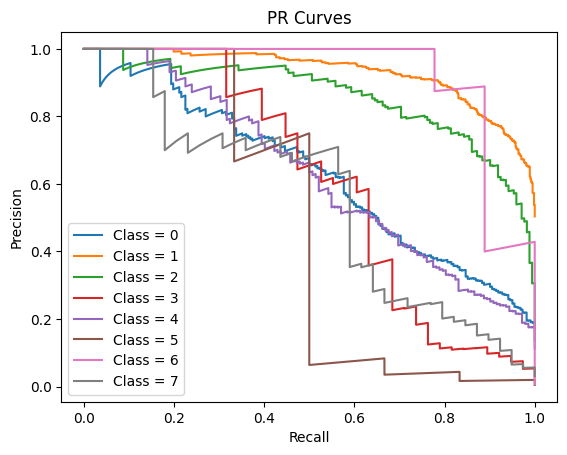

In [57]:
model_metrics(model5,test_loader,8)

In [ ]:
model_metrics(model6,test_loader,8)

In [ ]:
model_metrics(model7,test_loader,8)

Accuracy : 62.622272968292236
Precision: 70.70533037185669
Recall   : 62.622272968292236
F1-score : 65.21992683410645
Confusion Matrix:
 [[115  81  13   6   6   1   0   0]
 [ 34 570  21   1  10   0   2   0]
 [  3   6 156   1   4   1   0   1]
 [  0   5  10  21   1   0   0   1]
 [ 24  38  10   2  64   0   0   4]
 [  1   1   1   0   0   3   0   0]
 [  0   1   1   0   0   0   7   0]
 [  3   2  17   0   1   0   0  16]]
AOC: 0.9302569627761841
Raw Accuracy: 75.20


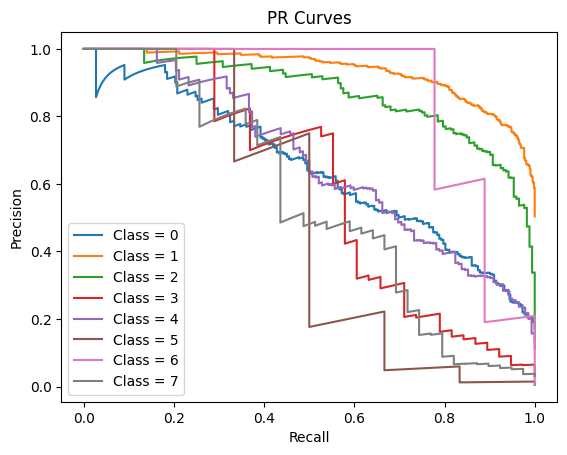

In [58]:
model_metrics(model8,test_loader,8)

Accuracy : 49.74115788936615
Precision: 52.973318099975586
Recall   : 49.74115788936615
F1-score : 50.38708448410034
Confusion Matrix:
 [[167  33  13   4  16   0   1   6]
 [100 452  31   2  57   1   1   2]
 [ 10   8 109   4  14   2   0   5]
 [  7   6  13  10   6   0   0   1]
 [ 30  21  15   3  58   0   0   5]
 [  0   1   3   0   0   4   0   0]
 [  0   3   3   0   0   0   7   0]
 [ 10   2   9   4   2   0   0   5]]
AOC: 0.8869491219520569
Raw Accuracy: 64.14


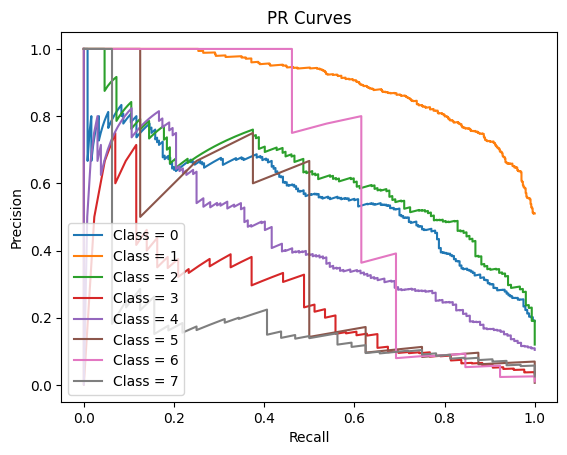

In [305]:
model_metrics(model1,test_loader,8)

Accuracy : 57.963693141937256
Precision: 46.128857135772705
Recall   : 57.963693141937256
F1-score : 49.604034423828125
Confusion Matrix:
 [[125  30  14  13  51   1   0   6]
 [ 99 420  31   5  71  10   3   7]
 [  7   7  85  18  17   3   2  13]
 [  2   1   7  23   6   0   0   4]
 [ 17  17   8  14  71   0   2   3]
 [  0   0   1   0   1   6   0   0]
 [  0   3   2   0   0   0   8   0]
 [  2   1   4   6   4   0   0  15]]
AOC: 0.8811367154121399
Raw Accuracy: 59.48


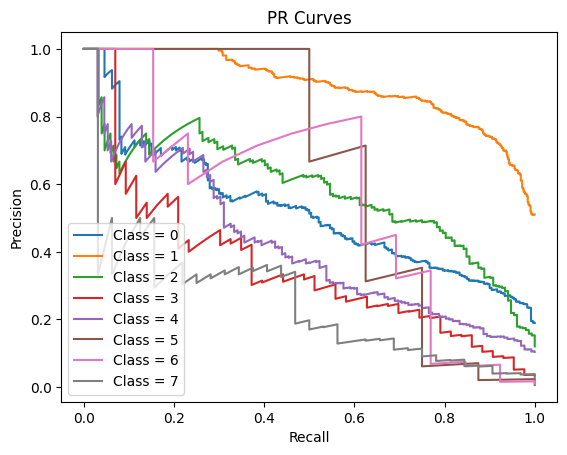

In [306]:
model_metrics(model2,test_loader,8)

Accuracy : 49.698129296302795
Precision: 48.781853914260864
Recall   : 49.698129296302795
F1-score : 48.445504903793335
Confusion Matrix:
 [[124  67  11   5  26   0   0   7]
 [ 54 526  12   1  39   4   2   8]
 [ 15  12  83   8  14   7   0  13]
 [  2   5  12  10  12   0   0   2]
 [ 23  24  10   5  62   1   1   6]
 [  0   3   1   0   0   3   0   1]
 [  0   4   0   0   1   0   8   0]
 [  5   2   9   0   3   0   0  13]]
AOC: 0.8870701789855957
Raw Accuracy: 65.48


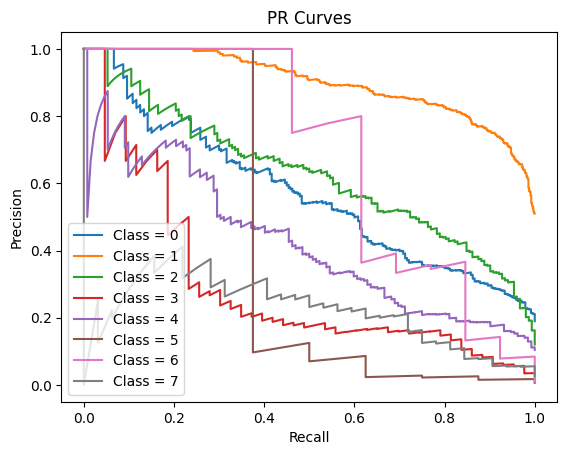

In [307]:
model_metrics(model3,test_loader,8)

Accuracy : 53.59727740287781
Precision: 47.42124676704407
Recall   : 53.59727740287781
F1-score : 47.8390246629715
Confusion Matrix:
 [[ 66  53  22  27  61   1   0  10]
 [ 44 457  39  15  83   2   1   5]
 [  1   6  87  27  12   5   0  14]
 [  1   1   8  25   7   0   0   1]
 [ 11  13  15  17  73   0   1   2]
 [  0   0   1   1   1   4   0   1]
 [  0   3   1   0   0   0   9   0]
 [  2   0   6   8   2   1   0  13]]
AOC: 0.8824692964553833
Raw Accuracy: 57.98


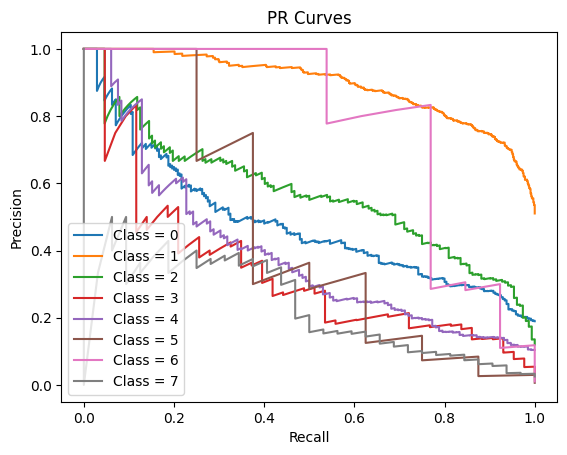

In [308]:
model_metrics(model4,test_loader,8)